---
# Create main input .yaml file for monte carlo setup
---

Use `analysis-rachael/env/monte_carlo.yaml` to create an environment for this notebook:
```
 conda env create -f [analysis-rachael/env/monte_carlo.yaml]
```
or, to activate this environment, use
```
 conda activate monte-carlo
```
To deactivate an active environment, use
```
 conda deactivate
```

---
# Create main .yaml
---

In [1]:
import sys
import yaml
import pathlib
import numpy
import pandas
import matplotlib.pyplot as plt
import os
import warnings
from dask import delayed
from monte_carlo_utils import make_bins, get_bin, place_into_bins, decimal_divide
from monte_carlo_utils import get_DOE_atb, get_DOE_barges
from monte_carlo_utils import get_voyage_transfers, assign_facility_region, concat_shp
# for handymax tankers
from monte_carlo_utils import split_doe_transfers, get_doe_tanker_byvessel

### Set values used in calcuations

In [2]:
# This is the precision used to calculate weights 
precision = 2

### Define Directories & Create Dictionary Structure
- See [QAQC_Tanker_AISlengths_DOEcapacities](https://github.com/MIDOSS/analysis-rachael/tree/main/notebooks/monte_carlo) notebook for information on handymax_capacity.yaml

In [3]:
# Initialize dictionaries used in this notebook 
# Master dictionary used to output values to oil_attribution.yaml
oil_attrs = {}

# AIS ship track dictionary, collating 2018 data by vessel types 'tanker','atb','barge'
allTracks = {}

# Handymax cargo capacity and probability
mmsi_names = {}
N_MMSI = {} # number of mmsi in each size class
volume = {}
one_way = {} # import or export at marine terminal stop
two_way = {} # both import and export at marine terminal stop
handyVoyages = {}
capacity = {} # cargo capacity weights and values

In [4]:
#~~~ create dictionary structure ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# create a section for directories and filenames
oil_attrs['directories'] = {}
oil_attrs['directories']['root'] = pathlib.Path('/data/MIDOSS/')
oil_attrs['directories']['data'] = oil_attrs['directories']['root'] / 'marine_transport_data/'
oil_attrs['directories']['shapefiles'] = oil_attrs['directories']['root'] / 'shapefiles/' 
oil_attrs['directories']['spreadsheets'] = oil_attrs['directories']['root'] / 'spreadsheets'
oil_attrs['directories']['graphics'] = oil_attrs['directories']['root'] / 'graphics'

# to support smaller line lengths
ddata = oil_attrs['directories']['data']
dsprd = oil_attrs['directories']['spreadsheets']

# Create dictionary of file names and locations
oil_attrs['files'] = {} 
oil_attrs['files']['output_file']    = ddata/'oil_attribution.yaml'
oil_attrs['files']['ais_ping_data']  = ddata/'Origin_Destination_Analysis_updated.xlsx'
oil_attrs['files']['doe_transfers']  = dsprd/'MuellerTrans4-30-20.xlsx'    
oil_attrs['files']['oil_facilities'] = ddata/'Oil_Transfer_Facilities.xlsx'
# yaml files with Dept. of Ecology oil transfer data 
# US_origin is for US as origin 
# US_all represents the combined import and export of fuel
oil_attrs['files']['CAD_origin']     = ddata/'CAD_origin.yaml'
oil_attrs['files']['WA_destination'] = ddata/'WA_destination.yaml'
oil_attrs['files']['WA_origin']      = ddata/'WA_origin.yaml'
oil_attrs['files']['US_origin']      = ddata/'US_origin.yaml'
oil_attrs['files']['US_combined']    = ddata/'US_general.yaml'
oil_attrs['files']['Pacific_origin'] = ddata/'Pacific_origin.yaml'
oil_attrs['files']['fuel']           = ddata/'fuel_by_vessel.yaml'
oil_attrs['files']['fill_fraction']  = ddata/'fill_fraction.yaml'

# excel spreadsheet with oil capacity data for all vessel types
oil_attrs['files']['oil_capacity']   = ddata/'oil_capacity.xlsx'

# yaml file for special case of Handimax tanker cargo capacity
oil_attrs['files']['handimax_capacity']  = ddata/'handymax_capacity.yaml'

# weights for allocating tank barge capacities for ATBs < 50 m and tank barges 
oil_attrs['files']['barge_weights']  = ddata/'barge_capacity.yaml'

#~~~ Model setup categories ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# create a section for general categories 
oil_attrs['categories'] = {}

# labels for AIS ship traffic groups
oil_attrs['categories']['all_vessels'] = [
    'tanker', 
    'atb', 
    'barge', 
    'cargo', 
    'cruise',
    'ferry', 
    'fishing', 
    'smallpass', 
    'other'
]

# labels for oil tank traffic identified in AIS
oil_attrs['categories']['tank_vessels'] = [
    'tanker', 
    'atb', 
    'barge'
]

# tanker size classes 
oil_attrs['categories']['tanker_size_classes'] = [
    "Smallest Tanker (< 60 m)"
    "Small Tanker (61 - 150 m)", 
    "Handymax (151-200 m)", 
    "Aframax (201-250 m)", 
    "SuezMax (251-300 m)" 
]

# fuel types used in categorizing Dept. of Ecology data and 
# for which we have Lagrangian files 
# Most "other" is CatFeed VGO, which we characterize as Bunker
oil_attrs['categories']['fuel_type']    = [
    'akns', 
    'bunker', 
    'dilbit', 
    'jet', 
    'diesel', 
    'gas', 
    'other'
]

# Labels given to ship tracks in our AIS origin-destination analysis.
# Generic attributions are given for voyages > 2 km with a start and/or end 
# that isn't close enough to marine terminal to attribute to a marine terminal.
oil_attrs['categories']['generic_origin_destination'] = [
    'Pacific',
    'US',
    'Canada'
]
oil_attrs['categories']['CAD_origin_destination'] = [
    'ESSO Nanaimo Departure Bay',
    'Suncor Nanaimo',
    'Shell Chemainus Bare Point',
    'Chevron Cobble Hill',
    'Chevron Stanovan',
    'Barge Mooring Near Stanovan',
    'Shell Shellburn',
    'Westridge Marine Terminal',
    'ESSO IOCO Vancouver',
    'Suncor Vancouver'
]
# Terminals that are grouped in voyage joins are removed, e.g.:
# 'Maxum Petroleum - Harbor Island Terminal' and 
# 'Shell Oil LP Seattle Distribution Terminal' are represented by
# 'Kinder Morgan Liquids Terminal - Harbor Island'. 
# 'Nustar Energy Tacoma' is represented by 'Phillips 66 Tacoma Terminal'
oil_attrs['categories']['US_origin_destination'] = [ 
    'BP Cherry Point Refinery', 
    'Shell Puget Sound Refinery', 
    'Tidewater Snake River Terminal', 
    'SeaPort Sound Terminal', 
    'Tesoro Vancouver Terminal',
    'Phillips 66 Ferndale Refinery', 
    'Phillips 66 Tacoma Terminal', 
    'Marathon Anacortes Refinery (formerly Tesoro)',
    'Tesoro Port Angeles Terminal',
    'U.S. Oil & Refining',
    'Naval Air Station Whidbey Island (NASWI)',
    'NAVSUP Manchester', 
    'Alon Asphalt Company (Paramount Petroleum)', 
    'Kinder Morgan Liquids Terminal - Harbor Island',
    'Nustar Energy Vancouver',
    'Tesoro Pasco Terminal', 
    'REG Grays Harbor, LLC', 
    'Tidewater Vancouver Terminal',
    'TLP Management Services LLC (TMS)']

# ~~~ Create dictionary structure for vessel attributes  ~~~~~~~~~~~~~~~~~~~~

# create sections organized by vessel type
oil_attrs['vessel_attributes'] = {}

for vessels in oil_attrs['categories']['all_vessels']:
    oil_attrs['vessel_attributes'][vessels] = {}

# Load oil capacity data

In [5]:
#~~~ tanker traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
tanker_df = pandas.read_excel(
    oil_attrs['files']['oil_capacity'],
    sheet_name='tanker', 
    usecols='B,C,F,G,H,I'
)
#~~~ atb traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# fuel and cargo capacity information
# K: "Vessel length (AIS)"
# L: "Vessel Length (AIS + <50 m correction)"
# O: "Total Fuel Capacity (liters)"
# P: "Cargo Capacity (liters)"

atb_df = pandas.read_excel(
    oil_attrs['files']['oil_capacity'],
    sheet_name='atb', 
    usecols='K,L,O,P',
    skiprows=1
)

# AIS information
# B: COUNT, 
# C: LENGTH, 
# D: Median time
atb_data_df = pandas.read_excel(
    oil_attrs['files']['oil_capacity'],
    sheet_name='atb data', 
    usecols='B,C,D'
)
#~~~ cargo traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cargo_df = pandas.read_excel(
    oil_attrs['files']['oil_capacity'],
    sheet_name='cargo', 
    usecols='B,D,I,J'
)
#~~~ cruise traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cruise_df = pandas.read_excel(
    oil_attrs['files']['oil_capacity'],
    sheet_name='cruise', 
    usecols='B,D,I,J'
)
#~~~ ferry traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ferry_df = pandas.read_excel(
    oil_attrs['files']['oil_capacity'],
    sheet_name='ferry', 
    usecols='B,D,I,J'
)
#~~~ small passenger traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
smallpass_df = pandas.read_excel(
    oil_attrs['files']['oil_capacity'],
    sheet_name='smallpass', 
    usecols='B,D'
)
#~~~ fishing traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fishing_df = pandas.read_excel(
    oil_attrs['files']['oil_capacity'],
    sheet_name='fishing', 
    usecols='A,C,I,J'
)

---

# Estimate probabilities of barge oil cargo based on ATB ship tracks and oil transfer data
This code was developed in `Quantify_AIS_barge_attributions.ipynb`

## Concatenate all monthly ship track data to get values for entire year

In [6]:
%%time
allTracks["tanker"] = concat_shp("tanker", oil_attrs['directories']['shapefiles'])
allTracks["tanker"] = allTracks["tanker"].reset_index(drop=True)

creating tanker shapefile for 2018, starting with January data
Concatenating tanker data from month 2
Concatenating tanker data from month 3
Concatenating tanker data from month 4
Concatenating tanker data from month 5
Concatenating tanker data from month 6
Concatenating tanker data from month 7
Concatenating tanker data from month 8
Concatenating tanker data from month 9
Concatenating tanker data from month 10
Concatenating tanker data from month 11
Concatenating tanker data from month 12
CPU times: user 1min 8s, sys: 1.57 s, total: 1min 9s
Wall time: 1min 10s


# Calculate values for Handymax size tankers

0 19025.0
1 84730.0
2 572427.0
3 142846.0
4 272345.0


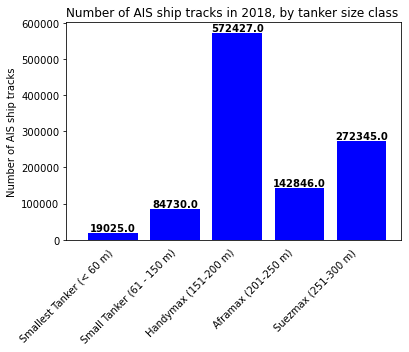

In [7]:
# Create bins for size classes
bins = []
bins.append((0, 60))
bins.append((61, 150))
bins.append((151, 200))
bins.append((201, 250))
bins.append((251, 300))

# Create list of names for tanker size classes evaluated
size_classes = [
    "Smallest Tanker (< 60 m)",
    "Small Tanker (61 - 150 m)", 
    "Handymax (151-200 m)", 
    "Aframax (201-250 m)", 
    "Suezmax (251-300 m)" 
]

binned_data = numpy.zeros(len(bins))
binned_mmsi = pandas.DataFrame(columns = size_classes)
for idx,value in enumerate(allTracks["tanker"]["LENGTH"]):
    if value > 0:
        bin_index = get_bin(value, bins)  
        binned_data[bin_index] += 1
        
fig, ax = plt.subplots()    
#width = 0.75 # the width of the bars 
ind = numpy.arange(len(binned_data))  # the x locations for the groups
ax.bar(ind, binned_data, color="blue")
ax.set_xticks(ind-3/4)
ax.set_xticklabels(size_classes, minor=False, rotation=45)
ax.tick_params(axis = "x", which = "both", bottom = False, top = False)
plt.title('Number of AIS ship tracks in 2018, by tanker size class ')
#plt.xlabel('Tanker size class', rotation=45)
plt.ylabel('Number of AIS ship tracks')
for i, v in enumerate(binned_data):
    print(i,v)
    ax.text(i, v, str(v), color='black', fontweight='bold', ha='center', va='bottom')
    
plt.savefig(oil_attrs['directories']['graphics'] / 'AIS_tracks_by_sizeclass_2018.png', 
            bbox_inches='tight'
           )

## Link vessel names to MMSI with the most AIS ship tracks in 2018, by category
- See [QAQC_Tanker_AISlength_DOECapacities.ipynb](https://github.com/MIDOSS/analysis-rachael/blob/main/notebooks/monte_carlo/QAQC_Tanker_AISlengths_DOEcapacities.ipynb) for vessel ranking and selection using `binned_mmsi`

In [8]:
mmsi_names["Smallest Tanker (< 60 m)"]= {
    368009250:"GLOBAL PROVIDER"
}
mmsi_names["Small Tanker (61 - 150 m)"] = {
    355320000:"KIRKEHOLMEN",
    566306000:"MTM HOUSTON",
    477636500:"BOCHEM LONDON"
}
mmsi_names["Handymax (151-200 m)"] = {
    369042000:"AMERICAN FREEDOM",
    367353110:"PELICAN STATE", 
    366855000:"FLORIDA", 
    367134000:"OVERSEAS LOS ANGELES",
    369040000:"AMERICAN ENDURANCE",
    356159000:"OPEC VICTORY",
    212656000:"PANAGIA THALASSINI",
    538006302:"SONGA PRIDE",
    538004682:"ZAO GALAXY",
    538007277:"CHEMBULK LINDY ALICE",
    538004167:"ARGENT IRIS",
    338221000:"OVERSEAS BOSTON",
    477185200:"RAINBOW STAR",
    538005425:"STI BATTERY",
    636017622:"HIGH CHALLENGE",
    538006892:"NAVIG8 SPARK",
    563054800:"NAEBA GALAXY",
    563046100:"HODAKA GALAXY",
    367353070:"EVERGREEN STATE",
    566150000:"MAERSK TIANJIN",
}
mmsi_names["Aframax (201-250 m)"] = {         
    636015178:"AQUALEGACY",
    220518000:"TORM EMILIE",
    255806154:"NORDTULIP",
    311943000:"GULF PEARL",
    538001893:"ELAN VITAL"
}
mmsi_names["Suezmax (251-300 m)"] = {
    303294000:"ALASKAN EXPLORER",
    367688000:"ALASKAN NAVIGATOR", 
    303656000:"ALASKA LEGEND", 
    366948190:"ALASKA FRONTIER"
}

# Count the number of MMSI used in each size class to evaluate cargo capacity using the DOE database
N_MMSI["Smallest"] = len(mmsi_names["Smallest Tanker (< 60 m)"])
N_MMSI["Small"] = len(mmsi_names["Small Tanker (61 - 150 m)"])
N_MMSI["Handymax"] = len(mmsi_names["Handymax (151-200 m)"])
N_MMSI["Aframax"] = len(mmsi_names["Aframax (201-250 m)"])
N_MMSI["Suezmax"] = len(mmsi_names["Suezmax (251-300 m)"])

#### Divide transfers into those with both import and export vs. one-way only:
- 100% full tankers that have import and export transfers per terminal stop ("double" transfer) and 
- 50% tankers that have either import or export ("single" transfer) 

In [9]:
for idx,vessel_type in enumerate([*N_MMSI]):
    # get list of vessel names by size class
    vessels = list(mmsi_names[[*mmsi_names][idx]].values())
    volume[vessel_type] = get_doe_tanker_byvessel(
        vessels, 
        oil_attrs['files']['doe_transfers'], 
        oil_attrs['files']['oil_facilities'])
    volume[vessel_type] = volume[vessel_type].sort_values(by='StartDateTime').reset_index()
for idx,vessel_type in enumerate([*N_MMSI]):
    one_way[vessel_type], two_way[vessel_type]  = split_doe_transfers(
        volume[vessel_type])
    print(f'{vessel_type}: {one_way[vessel_type].shape[0]} one-way, {two_way[vessel_type].shape[0]} two-way transfers')    

Smallest: 35 one-way, 2 two-way transfers
Small: 48 one-way, 0 two-way transfers
Handymax: 134 one-way, 93 two-way transfers
Aframax: 8 one-way, 2 two-way transfers
Suezmax: 39 one-way, 3 two-way transfers


### Calculate probability of full tanker for handimax

In [10]:
handyVoyages['full'] = two_way['Handymax'].shape[0]
handyVoyages['half_full'] = 2*one_way['Handymax'].shape[0]
handyVoyages['total'] = handyVoyages['full']+handyVoyages['half_full']
full_handymax = (1.0 * handyVoyages['full']/handyVoyages['total'] +
                 0.5 * handyVoyages['half_full']/handyVoyages['total'])

### Calculate Handymax cargo capacity bins and weights

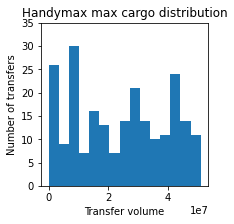

In [11]:
nbins = 15
max_full = max(volume['Handymax']['TransferQtyInLiters'])
bin_values = numpy.arange(
    0,
    max_full + max_full/nbins,
    max_full/nbins
)

fig, ax = plt.subplots(figsize = (3,3))
n, cargo_capacity, patches = ax.hist(
        volume['Handymax']['TransferQtyInLiters'],
        bins = bin_values)
ax.set_xlabel('Transfer volume')
ax.set_ylabel('Number of transfers')
ax.set_ylim(0,35)
ax.set_title(f'Handymax max cargo distribution')
plt.savefig(oil_attrs['directories']['graphics'] / 'Handymax_cargo_distribution_2018.png', 
            bbox_inches='tight'
           )

In [12]:
weights = n/sum(n)
capacity['weights'] = weights.tolist()
capacity['amount_in_liters'] = cargo_capacity.tolist()
capacity['amount_in_liters'].pop(0) # Remove zero (lower bound of first bin)
print(f'{len(capacity["amount_in_liters"])} =? {len(capacity["weights"])}')
capacity

15 =? 15


{'weights': [0.1145374449339207,
  0.039647577092511016,
  0.13215859030837004,
  0.030837004405286344,
  0.07048458149779736,
  0.05726872246696035,
  0.030837004405286344,
  0.06167400881057269,
  0.09251101321585903,
  0.06167400881057269,
  0.04405286343612335,
  0.048458149779735685,
  0.10572687224669604,
  0.06167400881057269,
  0.048458149779735685],
 'amount_in_liters': [3402326.5080000004,
  6804653.016000001,
  10206979.524,
  13609306.032000002,
  17011632.540000003,
  20413959.048,
  23816285.556,
  27218612.064000003,
  30620938.572000004,
  34023265.080000006,
  37425591.58800001,
  40827918.096,
  44230244.604,
  47632571.112,
  51034897.620000005]}

### ATBs

In [13]:
%%time
# Note: this implimenation of dask isn't effective.  Need to suss out a better approach. 
allTracks_dask = delayed(concat_shp("atb", oil_attrs['directories']['shapefiles']))
allTracks["atb"]=allTracks_dask.compute()

creating atb shapefile for 2018, starting with January data
Concatenating atb data from month 2
Concatenating atb data from month 3
Concatenating atb data from month 4
Concatenating atb data from month 5
Concatenating atb data from month 6
Concatenating atb data from month 7
Concatenating atb data from month 8
Concatenating atb data from month 9
Concatenating atb data from month 10
Concatenating atb data from month 11
Concatenating atb data from month 12
CPU times: user 36.9 s, sys: 724 ms, total: 37.6 s
Wall time: 38.3 s


### Barges

In [14]:
%%time
allTracks_dask = delayed(concat_shp("barge", oil_attrs['directories']['shapefiles']))
allTracks["barge"]=allTracks_dask.compute()

creating barge shapefile for 2018, starting with January data
Concatenating barge data from month 2
Concatenating barge data from month 3
Concatenating barge data from month 4
Concatenating barge data from month 5
Concatenating barge data from month 6
Concatenating barge data from month 7
Concatenating barge data from month 8
Concatenating barge data from month 9
Concatenating barge data from month 10
Concatenating barge data from month 11
Concatenating barge data from month 12
CPU times: user 14min 35s, sys: 33.4 s, total: 15min 8s
Wall time: 15min 10s


## Find all ATB and barge tracks with generic attribution as both origin and destination

In [15]:
attribution = ['US','Canada','Pacific']
noNone = {}
allNone = {}
generic = {}

for vessel_type in ["atb",'barge']:
    generic[vessel_type] = allTracks[vessel_type].loc[
        (allTracks[vessel_type].TO.isin(attribution)) & 
        (allTracks[vessel_type].FROM_.isin(attribution))
    ]    

## Find all ship tracks with None as origin or destination

In [16]:
for vessel_type in ["atb",'barge']:
    # keep rows with None attribution 
    shp_tmp = allTracks[vessel_type].isnull()
    row_has_None = shp_tmp.any(axis=1)
    allNone[vessel_type] = allTracks[vessel_type][row_has_None]

## Find all ship tracks with any WA or CAD marine oil terminal as either origin or destination

In [17]:
allfacWACAD = {}
# import facility locations
facWA = pandas.read_excel(
    oil_attrs['files']['oil_facilities'],
    sheet_name = 'Washington',
    usecols="B,D,J,K"
)
# import facility locations
facCAD = pandas.read_excel(
    oil_attrs['files']['oil_facilities'],
    sheet_name = 'British Columbia',
    usecols="A",
    nrows=10
)
# find all vessels with oil terminals as origin or destination
for vessel_type in ["atb","barge"]:
    allfacWACAD[vessel_type] = allTracks[vessel_type].loc[
        ((allTracks[vessel_type].TO.isin(facWA.FacilityName)) |
         (allTracks[vessel_type].FROM_.isin(facWA.FacilityName))|
         (allTracks[vessel_type].TO.isin(facCAD.Name)) |
         (allTracks[vessel_type].FROM_.isin(facCAD.Name))
        )
    ]

In [18]:
print(f'TEST ATBs: All tracks = Generic + allFacWACAD + allNone')
print(f'{allTracks["atb"].shape[0]} = {generic["atb"].shape[0] + allfacWACAD["atb"].shape[0] + allNone["atb"].shape[0]}')

TEST ATBs: All tracks = Generic + allFacWACAD + allNone
588136 = 588136


In [19]:
# create a dictionary of ratios between subsampled data and all ship tracks
frac = {}
frac['atb'] = {}
frac['barge'] = {}
for vessel_type in ["atb","barge"]:
    frac[vessel_type]["unattributed"] = allNone[vessel_type].shape[0]/allTracks[vessel_type].shape[0]
    frac[vessel_type]["generic"] = generic[vessel_type].shape[0]/allTracks[vessel_type].shape[0]
    frac[vessel_type]["marine_terminal_WACAD"] = allfacWACAD[vessel_type].shape[0]/allTracks[vessel_type].shape[0]
    print(f'~~~  {vessel_type} ~~~')
    print(f'Fraction of {vessel_type} tracks that are unattributed: {frac[vessel_type]["unattributed"]}')
    print(f'Fraction of attributed {vessel_type} tracks that are generic : {frac[vessel_type]["generic"]}')
    print(f'Fraction of attributed {vessel_type} tracks that are linked to marine terminal (WACAD): {frac[vessel_type]["marine_terminal_WACAD"]}')

~~~  atb ~~~
Fraction of atb tracks that are unattributed: 0.38799359331855215
Fraction of attributed atb tracks that are generic : 0.20288334670892447
Fraction of attributed atb tracks that are linked to marine terminal (WACAD): 0.40912305997252335
~~~  barge ~~~
Fraction of barge tracks that are unattributed: 0.4340840929832173
Fraction of attributed barge tracks that are generic : 0.4218586544846484
Fraction of attributed barge tracks that are linked to marine terminal (WACAD): 0.1440572525321343


In [20]:
for vessel_type in ["atb","barge"]:
    print(f'Total number of tracks for {vessel_type}: {allTracks[vessel_type].shape[0]:1.2e}')

Total number of tracks for atb: 5.88e+05
Total number of tracks for barge: 1.39e+07


## Quantify barge and ATB cargo transfers in 2018 DOE database

In [21]:
[atb_in, atb_out]=get_DOE_atb(
    oil_attrs['files']['doe_transfers'], 
    oil_attrs['files']['oil_facilities'], 
    transfer_type = 'cargo', 
    facilities='selected'
)
barge_inout=get_DOE_barges(
    oil_attrs['files']['doe_transfers'],
    oil_attrs['files']['oil_facilities'], 
    direction='combined',
    facilities='selected',
    transfer_type = 'cargo')
# Quantify transfers
transfers = {}
transfers["barge"] = barge_inout.shape[0]
transfers["atb"] = atb_in.shape[0] + atb_out.shape[0]
print(f'{transfers["atb"]} cargo transfers for atbs')
print(f'{transfers["barge"]} cargo transfers for barges')
### Group barge and atb transfers by AntID and:
# - compare transfers
# - compare fraction of grouped transfers to ungrouped transfers by vessel type
transfers["barge_antid"] = barge_inout.groupby('AntID').sum().shape[0]
transfers["atb_antid"] = atb_in.groupby('AntID').sum().shape[0] + atb_out.groupby('AntID').sum().shape[0]
print(f'{transfers["atb_antid"]} ATB cargo transfers based on AntID')
print(f'{transfers["atb_antid"]/transfers["atb"]:.2f} ATB fraction AntID to all')
print(f'{transfers["barge_antid"]} barge cargo transfers based on AntID')
print(f'{transfers["barge_antid"]/transfers["barge"]:.2f} barge fraction AntID to all')

get_DOE_barges: not yet tested with fac_xls as input
combined
cargo
cargo
677 cargo transfers for atbs
2773 cargo transfers for barges
482 ATB cargo transfers based on AntID
0.71 ATB fraction AntID to all
2334 barge cargo transfers based on AntID
0.84 barge fraction AntID to all


##### Take away: Barge and ATBs have similar number of mixed-oil-type transfers with ATBs having more mixed-type transfers (29% of 677) than barges (16% of 2334).  Even though values are similar, we will use the AntID grouped number of transfers for our ping to transfer ratios

### Calculate the number of oil cargo barges we expect using the AntID grouping for ping-to-transfer ratio

In [22]:
ping2transfer = {}
oilcargobarges = {}
# ATB ping-to-transfer ratio
ping2transfer["atb"] = allTracks["atb"].shape[0]/transfers["atb_antid"]
# Estimate number of oil cargo barges using number of barge transfers 
# and atb ping-to-transfer ratio
oilcargobarges["total"] = transfers["barge_antid"]*ping2transfer["atb"]
print(f'We expect {oilcargobarges["total"]:.0f} total oil cargo pings for barge traffic')

We expect 2847945 total oil cargo pings for barge traffic


### Calculate the number of Attributed tracks we get for ATBs and estimate the equivalent value for barges

## Evaluate oil cargo traffic pings for ATBs and barges

In [23]:
# Dictionary for probability of oil cargo barges for our 3 attribution types
P_oilcargobarges = {}

# ~~~ facilities ~~~
# Ratio of ATB pings with WA facility attribution to ATB WA transfers
fac_att_ratio = allfacWACAD["atb"].shape[0]/transfers["atb_antid"]
# Fraction of barge pings with generic attribution that are expected to carry oil based on ATB pings and transfers
P_oilcargobarges["oil_terminal"] = fac_att_ratio*transfers["barge_antid"]/allfacWACAD["barge"].shape[0]

# ~~~ generic ~~~
# Ratio of ATB pings with generic attribution to ATB WA transfers
generic_ratio = generic["atb"].shape[0]/transfers["atb_antid"]
# Fraction of barge pings with generic attribution that are expected to carry oil based on ATB pings and transfers
P_oilcargobarges["generic"] = generic_ratio*transfers["barge_antid"]/generic["barge"].shape[0]

# ~~~ None ~~~
# Ratio of ATB pings with "None" attribution to ATB WA transfers
allNone_ratio = allNone["atb"].shape[0]/transfers["atb_antid"]
# Fraction of barge pings with None attribution that are expected to carry oil based on ATB pings and transfers
P_oilcargobarges["none"] = allNone_ratio*transfers["barge_antid"]/allNone["barge"].shape[0]

#### Find the probability of oil carge for each ping classification, i.e.:
- `oilcargobarges["total"]` = 588136.0 = (1) + (2) + (3), where 
- (1) `P_oilcargobarges["facilities"]` * `allfacWACAD["barges"].shape[0]`  
- (2) `P_oilcargobarges["none"]` * `allNone["barges"].shape[0]`  
- (3) `P_oilcargobarges["generic"]` * `generic["barges"].shape[0]`  

In [24]:
oilcargobarges = {}
oilcargobarges["total"] = transfers["barge_antid"]*ping2transfer["atb"]
oilcargobarges["facilities"] = (P_oilcargobarges["oil_terminal"] * allfacWACAD["barge"].shape[0])
oilcargobarges["none"] = (P_oilcargobarges["none"] * allNone["barge"].shape[0])
oilcargobarges["generic"] = (P_oilcargobarges["generic"] * generic["barge"].shape[0])
print('oilcargobarges["total"] = oilcargobarges["facilities"] + oilcargobarges["none"] + oilcargobarges["generic"]?')
#oilcargobarges_sum = oilcargobarges["facilities"] + oilcargobarges["none"] + oilcargobarges["generic"]
print(f'{oilcargobarges["total"]:.0f} =? {oilcargobarges["facilities"] + oilcargobarges["none"] + oilcargobarges["generic"]:.0f}')
missing_pings = oilcargobarges["total"]-(oilcargobarges["facilities"] + oilcargobarges["none"] + oilcargobarges["generic"])
print(f' Missing {missing_pings} pings ({100*missing_pings/oilcargobarges["total"]:.0f}%)') 

oilcargobarges["total"] = oilcargobarges["facilities"] + oilcargobarges["none"] + oilcargobarges["generic"]?
2847945 =? 2847945
 Missing -4.656612873077393e-10 pings (-0%)


---

# Set probabilities and weights related to oil tank traffic
- See [this notebook](https://nbviewer.jupyter.org/github/MIDOSS/analysis-rachael/blob/main/notebooks/monte_carlo/QAQC_Tanker_AISlengths_DOEcapacities.ipynb) for information on the handymax special case.

In [25]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Set the probability of incident as fuel spill vs. cargo spill for 
#  oil-cargo vessels.  The following six values are for cases thare are 
#  identified as oil cargo vessels and determines if the spill from the oil 
#  cargo vessel is a fuel spill or a cargo spill.  
oil_attrs['vessel_attributes']['tanker']['probability_full']  = 0.5
oil_attrs['vessel_attributes']['tanker']['probability_empty'] = 1 - \
oil_attrs['vessel_attributes']['tanker']['probability_full']

oil_attrs['vessel_attributes']['atb']['probability_full']  = 0.5
oil_attrs['vessel_attributes']['atb']['probability_empty'] = 1 - \
oil_attrs['vessel_attributes']['atb']['probability_full']

# All barges are originally set as oil cargo barges but changed to fuel 
# barges based on `probability_oilcargo`, below.
oil_attrs['vessel_attributes']['barge']['probability_full']  = 0.5
oil_attrs['vessel_attributes']['barge']['probability_empty'] = 1 - \
oil_attrs['vessel_attributes']['barge']['probability_full']

# # Use special case for Handimax
oil_attrs['vessel_attributes']['tanker']['probability_full_handymax']  = full_handymax
oil_attrs['vessel_attributes']['tanker']['probability_empty_handymax'] = 1 - \
oil_attrs['vessel_attributes']['tanker']['probability_full_handymax']

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Add probability of oil cargo barge
# The above calculated `probability_oilcargo` relates to the following as
# total = P('None') * (Number of 'None' tracks) + 
#         P('Generic') * (Number of 'Generic' attributed tracks) + 
#         P('OilTerminal') * (Number of tracks attributed to oil terminals)
oil_attrs['vessel_attributes']['barge']['probability_oilcargo'] = {}
oil_attrs['vessel_attributes']['barge']['probability_oilcargo']['None'] = (
    P_oilcargobarges["none"]
)
oil_attrs['vessel_attributes']['barge']['probability_oilcargo']['Generic'] = (
    P_oilcargobarges["generic"]
)
oil_attrs['vessel_attributes']['barge']['probability_oilcargo']['OilTerminal'] = (
    P_oilcargobarges["oil_terminal"]
)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set distribution of cargo fill fraction
# These values are calculated in [make_ATB_fill_fraction.ipynb](https://github.com/MIDOSS/analysis-rachael/blob/main/notebooks/monte_carlo/make_ATB_fill_fraction.ipynb)
with open(oil_attrs['files']['fill_fraction']) as fill_fraction:
      cargo_dict = yaml.safe_load(fill_fraction)
for vessel in ['atb','barge']:
    oil_attrs['vessel_attributes'][vessel]['cargo_fill_fraction_bins'] = (
        cargo_dict['fill_fraction']
    )
    oil_attrs['vessel_attributes'][vessel]['cargo_fill_fraction_weights'] = (
        cargo_dict['weights']
    )

In [26]:
oil_attrs['vessel_attributes']['barge']['probability_oilcargo']

{'None': 0.18309521135382856,
 'Generic': 0.0985157663535479,
 'OilTerminal': 0.5817617106601806}

# Set fuel fill fraction for all traffic 
- fuel_fill_fraction: Percent fill of fuel tanks where fuel volume is determined by a fraction of fuel capacity ranging from 0.25 to 1.0 with value based on a flat, random distribution 


In [27]:
oil_attrs['vessel_attributes']['all'] = {}
oil_attrs['vessel_attributes']['all']['fuel_fill_fraction'] = [0.25, 1]

# Set Mix/Max thresholds

In [28]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## set minimum cargo capacities in liters
oil_attrs['vessel_attributes']['tanker']['min_cargo'] = 588253  # Smallest tanker in 2018 (Global Provider)
oil_attrs['vessel_attributes']['atb']['min_cargo']    = 4000000  # smallest load of known ATBs (Island Trader: oil_capacity.xlsx)
oil_attrs['vessel_attributes']['barge']['min_cargo']  = 1500000  # 1,589,900: 3A-10 of [DOE report](https://fortress.wa.gov/ecy/publications/documents/96250.pdf)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## set maximum cargo capacities in liters
oil_attrs['vessel_attributes']['tanker']['max_cargo'] = 185447000 # Corresponding to tank capacity of Suez-Max tankers as AIS data shows tanker lengths up to 287 m
oil_attrs['vessel_attributes']['atb']['max_cargo']    =  29413150 # largest load of known ATBs (Kirby 185-01: oil_capacity.xlsx)
oil_attrs['vessel_attributes']['barge']['max_cargo']  =  32000000 # 31,797,444: 3A-10 of [DOE report](https://fortress.wa.gov/ecy/publications/documents/96250.pdf)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Set fuel size classes 
# Tankers: SuezMax (285 m), Aframax (245 m), Handymax (180 m), Small Tanker (116 m), Smallest Tanker (42 m)
# Most tanker fuel information from
# https://silo.tips/download/suezmax-oil-tanker-tankers-166300-dwt
# Smallest size class from https://www.professionalmariner.com/global-provider/
oil_attrs['vessel_attributes']['tanker']['min_fuel']    = (
    tanker_df['total fuel capacity (liters)'][0].tolist()
)

oil_attrs['vessel_attributes']['atb']['min_fuel']       = 99000   # Based on Island Raider and Island Regent tugs in Charles Costanzo's `ATB Information AWO Edits`
oil_attrs['vessel_attributes']['barge']['min_fuel']     = 6000    # 5678 (F43): Harbour Tug
oil_attrs['vessel_attributes']['cargo']['min_fuel']     = 1500000 # 1,514,164
oil_attrs['vessel_attributes']['cruise']['min_fuel']    = 1000000 
oil_attrs['vessel_attributes']['ferry']['min_fuel']     = 30000   # 34,068
oil_attrs['vessel_attributes']['fishing']['min_fuel']   = 150
oil_attrs['vessel_attributes']['smallpass']['min_fuel'] = 100
oil_attrs['vessel_attributes']['other']['min_fuel']     = 100   # 22 (F52)

oil_attrs['vessel_attributes']['tanker']['min_length']    = 42
oil_attrs['vessel_attributes']['atb']['min_length']       = 22
oil_attrs['vessel_attributes']['barge']['min_length']     = 22
oil_attrs['vessel_attributes']['cargo']['min_length']     = 50
oil_attrs['vessel_attributes']['cruise']['min_length']    = 60
oil_attrs['vessel_attributes']['ferry']['min_length']     = 26
oil_attrs['vessel_attributes']['fishing']['min_length']   = 20
oil_attrs['vessel_attributes']['smallpass']['min_length'] = 10
oil_attrs['vessel_attributes']['other']['min_length']     = 10

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## set maximum fuel capacities in liters (to be filled in )
# NOTE: Max volume for ferries reflects WA ferries.  See "Other Ship Classifications"
# and Living Oceans information with reference to [BC ferries doc](http://ferriesbc.proboards.com/thread/7592/fueling-bcs-ferries)
oil_attrs['vessel_attributes']['tanker']['max_fuel']    = tanker_df['total fuel capacity (liters)'][3].tolist()
# NOTE: Ocean-going tank barge listed as 52,995,000 liters max fuel capacity 
# accoring to [NOAA](https://response.restoration.noaa.gov/about/media/how-much-oil-ship.html)
oil_attrs['vessel_attributes']['atb']['max_fuel']       = 550000    # Again, based on Dublin Sea Charles Costanzo's 
oil_attrs['vessel_attributes']['barge']['max_fuel']     = 710000    # 700,300: Ocean Tug (need to verify that we have them in S.S.)
oil_attrs['vessel_attributes']['cargo']['max_fuel']     = 17000000  
oil_attrs['vessel_attributes']['cruise']['max_fuel']    = 7570820   
oil_attrs['vessel_attributes']['ferry']['max_fuel']     = 500000     
oil_attrs['vessel_attributes']['fishing']['max_fuel']   = 300000    # (see p. 3A-6 of [DOE report](https://fortress.wa.gov/ecy/publications/documents/96250.pdf))
oil_attrs['vessel_attributes']['smallpass']['max_fuel'] = 12000     # 11356 (F41)
oil_attrs['vessel_attributes']['other']['max_fuel']     = 17000000     # 3,028 (F77): Cruising, sport fishing, sailing

oil_attrs['vessel_attributes']['tanker']['max_length']    = 300
oil_attrs['vessel_attributes']['atb']['max_length']       = 209
oil_attrs['vessel_attributes']['barge']['max_length']     = 100
oil_attrs['vessel_attributes']['cargo']['max_length']     = 369
oil_attrs['vessel_attributes']['cruise']['max_length']    = 334
oil_attrs['vessel_attributes']['ferry']['max_length']     = 168
oil_attrs['vessel_attributes']['fishing']['max_length']   = 200
oil_attrs['vessel_attributes']['smallpass']['max_length'] = 75
oil_attrs['vessel_attributes']['other']['max_length']     = 75

# Load Oil Capacity Data and Attribute Vessels

#### Special case for Handymax
- See [QAQC_Tanker_AISlengths_DOEcapacities.ipynb](https://nbviewer.jupyter.org/github/MIDOSS/analysis-rachael/blob/main/notebooks/monte_carlo/QAQC_Tanker_AISlengths_DOEcapacities.ipynb) for details

In [29]:
oil_attrs['vessel_attributes']['tanker']['handy_weights'] = capacity['weights']
oil_attrs['vessel_attributes']['tanker']['handy_capacity'] = capacity['amount_in_liters']

#### All others

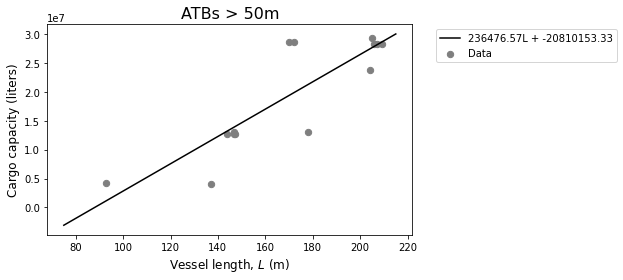

ATB cargo weight sum: 1.0
ATB fuel weight sum: 1.0


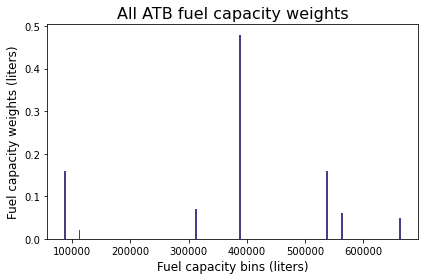

Cargo volume fit for length 620 m: 1.54680e+08
Cargo volume fit for length Benjamin Franklin (400 m, 1.4e7 liters): 1.80448e+07


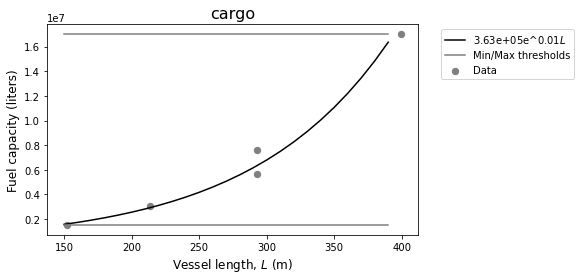

<Figure size 432x288 with 0 Axes>

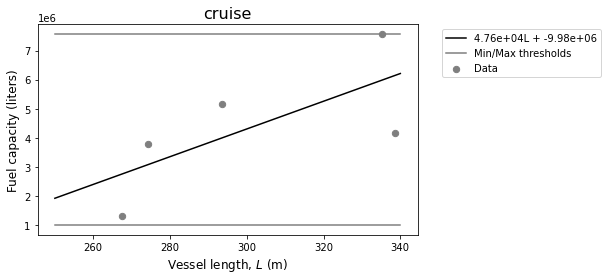

Ferry tank volume for length of 75 m: 6.22581e+04


<Figure size 432x288 with 0 Axes>

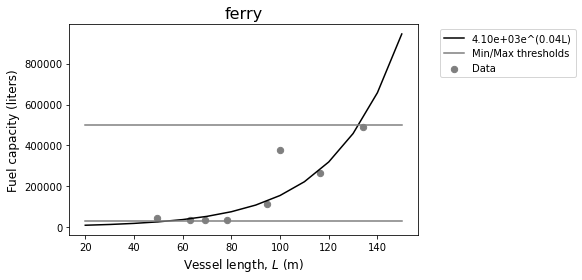

<Figure size 432x288 with 0 Axes>

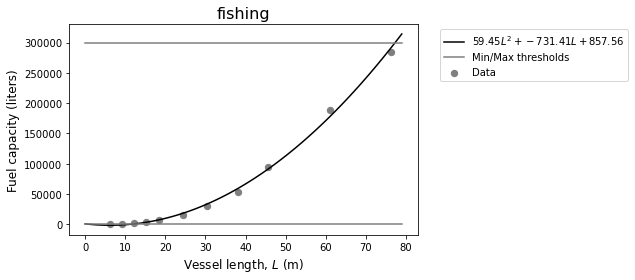

Small pass quadratic fit to 620m length: 4621120.77
Small pass quadratic fit to 400m length: 1909565.69
Small pass quadratic fit to 14m length: 1213.71
Small pass quadratic fit to 16m length: 1746.98
Small pass quadratic fit to 75m length: 61315.86


<Figure size 432x288 with 0 Axes>

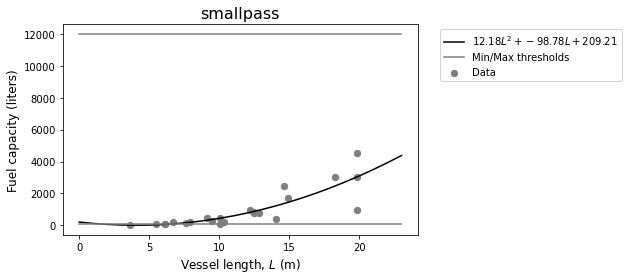

<Figure size 432x288 with 0 Axes>

In [30]:
oil_attrs['vessel_attributes']['tanker']['tanker_types'] = (
    oil_attrs['categories']['tanker_size_classes']
)

# fuel parameters
oil_attrs['vessel_attributes']['tanker']['fuel_hfo_to_diesel'] = (
    tanker_df['hfo fuel capacity (liters)'].values.flatten()/
    tanker_df['diesel fuel capacity (liters)'].values.flatten()
).tolist()

oil_attrs['vessel_attributes']['tanker']['fuel_capacity'] = (
    tanker_df['total fuel capacity (liters)'].values.flatten() 
).tolist()

# cargo parameters for all tankers
oil_attrs['vessel_attributes']['tanker']['cargo_capacity'] = (
    tanker_df['cargo capacity (liters)'].values.flatten() 
).tolist()

# create  bins for tanker categories
# Note: get_bin requires that adjacent bins share values.
# The sets are treated as: (0,60],(60,150],(150,200],(200,250] and (250,300]
bins = []
center_points = []
for index in range(len(tanker_df['min length (m)']-1)):
    bins.append(
        (tanker_df['min length (m)'][index].tolist(), 
         tanker_df['max length (m)'][index].tolist()+1)
    )
    step_size = (
        tanker_df['max length (m)'][index].tolist() - 
        tanker_df['min length (m)'][index].tolist()
    )
    center_points.append(tanker_df['min length (m)'][index] + step_size/2)

oil_attrs['vessel_attributes']['tanker']['length_bins'] = tuple(map(tuple, bins))

#~~~ atb traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# create line fit for atbs with length > 50 m
# fit = coefficient[1] + coefficient[0] * length
good_values = atb_df['Vessel Length (AIS + <50 m correction)']>0
atb_cargo_fit_coefs = numpy.polyfit(
    atb_df['Vessel Length (AIS + <50 m correction)'][good_values], 
    atb_df['Cargo Capacity (liters)'][good_values], 
    1
)
oil_attrs['vessel_attributes']['atb']['cargo_fit_coefs'] = (
    atb_cargo_fit_coefs.tolist()
)

fuel_fit_coefs= numpy.polyfit(
    atb_df['Vessel Length (AIS + <50 m correction)'][good_values], 
    atb_df['Total Fuel Capacity (liters)'][good_values], 
    1
)

oil_attrs['vessel_attributes']['atb']['fuel_fit_coefs'] = (
    fuel_fit_coefs.tolist()
)

########### PLOT ATB DATA FIT ###############
atb_length = numpy.arange(75, 225, 10)
C = atb_cargo_fit_coefs
atb_fit = (
    C[1]+
    C[0]*atb_length
)
fig = plt.figure()
ax1 = fig.add_subplot(111)

# add ais-curated frequency data 
good_data = atb_df['Vessel Length (AIS + <50 m correction)']>0
ax1.scatter(
    atb_df['Vessel Length (AIS + <50 m correction)'][good_values],
    atb_df['Cargo Capacity (liters)'][good_values],
    40,
    label='Data',
    color='tab:grey'
)

ax1.plot(
    atb_length, 
    atb_fit, 
    c='black', 
    label=f'{C[0]:.02f}L + {C[1]:.02f}'
)

plt.xlabel('Vessel length, $L$ (m)',fontsize=12)
plt.ylabel('Cargo capacity (liters)',fontsize=12)
plt.title('ATBs > 50m', fontsize=16)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.savefig(graphics_directory/'cargo_fit.png', bbox_inches='tight')
plt.show()
# plt.savefig(oil_attrs['directories']['graphics'] / 'ATBCargoFit_2018.png', 
#             bbox_inches='tight'
#            )

# create fuel and cargo capacity bins into which vessel traffic information 
# is sorted to determine oil capacity weights. 
[cargo_bins, cargo_bin_centers]  = make_bins(
    lower_bound =  4000000,
    upper_bound = 30000000,
    step_size   = 2000000
)

[fuel_bins, fuel_bin_centers]  = make_bins(
    lower_bound =  75000,
    upper_bound = 675000,
    step_size   =  25000
)

# we use the median time interval between AIS pings per MMSI vessel to scale
# the total AIS ship track count so that count isn't biased by ping interval.  
scaling_factor = ( atb_data_df['Median time between pings (minutes)'] / 
    numpy.median(atb_data_df['Median time between pings (minutes)'])
)
atb_scaled_count = (atb_data_df['COUNT'] * scaling_factor )


### cargo weights ###
# bin scaled count (above) by cargo capacity and sum AIS count for each 
# cargo capacity bin to create cargo capacity weights
binned_atb_count_cargo = place_into_bins(
    atb_df['Cargo Capacity (liters)'], 
    atb_scaled_count, 
    cargo_bins
)
numerator = binned_atb_count_cargo
denominator = binned_atb_count_cargo.sum()
cargo_weights = decimal_divide(
    numerator, 
    denominator, 
    precision
)

print(f'ATB cargo weight sum: {sum(cargo_weights)}')
    
# define weighting for oil capacity attribution for atbs < 50 m   
oil_attrs['vessel_attributes']['atb']['cargo_capacity_probability'] = (
    cargo_weights.tolist()
)
oil_attrs['vessel_attributes']['atb']['cargo_capacity_bin_centers'] = (
    cargo_bin_centers
)
oil_attrs['vessel_attributes']['atb']['cargo_capacity_bins'] = (
    cargo_bins
)

### fuel weights ### 
# bin distance travelled by fuel capacity and sum distances for each 
# fuel capacity bin to create fuel capacity weights
binned_atb_count_by_fuel = place_into_bins(
    atb_df['Total Fuel Capacity (liters)'], 
    atb_scaled_count, 
    fuel_bins
)
numerator = binned_atb_count_by_fuel
denomintor = binned_atb_count_by_fuel.sum()
fuel_weights = decimal_divide(
    numerator, 
    denominator, 
    precision
)
print(f'ATB fuel weight sum: {sum(fuel_weights)}')

oil_attrs['vessel_attributes']['atb']['fuel_capacity_probability']  = (
    fuel_weights.tolist()
)
oil_attrs['vessel_attributes']['atb']['fuel_capacity_bin_centers']  = (
    fuel_bin_centers
)
oil_attrs['vessel_attributes']['atb']['fuel_capacity_bins'] = (
    fuel_bins
)

fig = plt.figure()
ax2 = fig.add_subplot(111)

# add binned-ship-track frequencies
ax2.bar(
    fuel_bin_centers,
    fuel_weights,
    width=0.3e4,
    color='darkslateblue'
)
plt.xlabel('Fuel capacity bins (liters)',fontsize=12)
plt.ylabel('Fuel capacity weights (liters)',fontsize=12)
plt.title('All ATB fuel capacity weights', fontsize=16)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.savefig(graphics_directory/'cargo_fit.png', bbox_inches='tight')
plt.show()

#~~~ barge traffic (set to ATB) ~~~
# We use ATB traffic to determine barge weights b/c the number of ATB 
# vessels is manageable and has tugs paired with tank barges
oil_attrs['vessel_attributes']['barge']['cargo_capacity_probability'] = 'See ATB'
oil_attrs['vessel_attributes']['barge']['cargo_capacity_bin_centers'] = 'See ATB'
oil_attrs['vessel_attributes']['barge']['cargo_capacity_bins']        = 'See ATB'
oil_attrs['vessel_attributes']['barge']['fuel_capacity_probability']  = 'See ATB'
oil_attrs['vessel_attributes']['barge']['fuel_capacity_bin_centers']  = 'See ATB'
oil_attrs['vessel_attributes']['barge']['fuel_capacity_bins']         = 'See ATB'

#~~~ cargo traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
min_length = cargo_df['AIS min length'][0]
max_length = cargo_df['AIS max length'][0]
length = cargo_df['vessel length (m)']
capacity = cargo_df['fuel capacity (liters)']
vessel_type = 'cargo'

cargo_fit_coefs= numpy.polyfit(
    length, 
    numpy.log(capacity), 
    1
)

oil_attrs['vessel_attributes']['cargo']['fuel_fit_coefs'] = (
    cargo_fit_coefs.tolist()
)

cargo_length = numpy.arange(150, 400, 10)
C = cargo_fit_coefs
cargo_fit = (
    numpy.exp(C[1]) * 
    numpy.exp(C[0]*cargo_length)
)
print(f'Cargo volume fit for length 620 m: {numpy.exp(C[1]) *  numpy.exp(C[0]*620):1.5e}' )
print(f'Cargo volume fit for length Benjamin Franklin (400 m, 1.4e7 liters): {numpy.exp(C[1]) *  numpy.exp(C[0]*400):1.5e}' )
########### PLOT CARGO DATA FIT ###############
fig = plt.figure()
ax1 = fig.add_subplot(111)

# add ais-curated frequency data 
good_data = length>0
ax1.scatter(
    length[good_data],
    capacity[good_data],
    40,
    label='Data',
    color='tab:grey'
)

ax1.plot(
    cargo_length, 
    cargo_fit, 
    c='black', 
    label=f'{numpy.exp(C[1]):.02e}e^{C[0]:.02f}$L$'
)

ax1.plot(
    [numpy.min(cargo_length), numpy.max(cargo_length)],
    [oil_attrs['vessel_attributes']['cargo']['min_fuel'], 
     oil_attrs['vessel_attributes']['cargo']['min_fuel']],
    c='tab:grey',
    label='Min/Max thresholds'
)
ax1.plot(
    [numpy.min(cargo_length), numpy.max(cargo_length)],
    [oil_attrs['vessel_attributes']['cargo']['max_fuel'], 
     oil_attrs['vessel_attributes']['cargo']['max_fuel']],
    c='tab:grey'
)
plt.xlabel('Vessel length, $L$ (m)',fontsize=12)
plt.ylabel('Fuel capacity (liters)',fontsize=12)
plt.title(vessel_type, fontsize=16)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.savefig(graphics_directory/'cargo_fit.png', bbox_inches='tight')
plt.show()
plt.savefig(oil_attrs['directories']['graphics'] / 'CargoFit_2018.png', 
            bbox_inches='tight'
           )
#~~~ cruise traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
min_length = cruise_df['AIS min length'][0]
max_length = cruise_df['AIS max length'][0]
length = cruise_df['vessel length (m)']
capacity = cruise_df['fuel capacity (liters)']
vessel_type = 'cruise'

cruise_fit_coefs= numpy.polyfit(
    length, 
    capacity, 
    1
)

oil_attrs['vessel_attributes']['cruise']['fuel_fit_coefs'] = (
    cruise_fit_coefs.tolist()
)

cruise_length = numpy.arange(250, 350, 10)
C = cruise_fit_coefs
cruise_fit = (
    C[1] +
    C[0]*cruise_length
)

########### PLOT CRUISE DATA FIT ###############
fig = plt.figure()
ax1 = fig.add_subplot(111)

# add ais-curated frequency data 
good_data = length>0
ax1.scatter(
    length[good_data],
    capacity[good_data],
    40,
    label='Data',
    color='tab:grey'
)
ax1.plot(cruise_length,
         cruise_fit, 
         c='black', 
         label=f'{C[0]:.02e}L + {C[1]:.02e}'
        )
ax1.plot(
    [numpy.min(cruise_length), numpy.max(cruise_length)],
    [oil_attrs['vessel_attributes']['cruise']['min_fuel'], 
     oil_attrs['vessel_attributes']['cruise']['min_fuel']],
    c='tab:grey',
    label='Min/Max thresholds'
)
ax1.plot(
    [numpy.min(cruise_length), numpy.max(cruise_length)],
    [oil_attrs['vessel_attributes']['cruise']['max_fuel'], 
     oil_attrs['vessel_attributes']['cruise']['max_fuel']],
    c='tab:grey'
)

plt.xlabel('Vessel length, $L$ (m)',fontsize=12)
plt.ylabel('Fuel capacity (liters)',fontsize=12)
plt.title(vessel_type, fontsize=16)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.savefig(graphics_directory/'cruise_fit.png', bbox_inches='tight')
plt.show()
plt.savefig(oil_attrs['directories']['graphics'] / 'CruiseFit_2018.png', 
            bbox_inches='tight'
           )
#~~~ ferry traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
min_length = ferry_df['AIS min length'][0]
max_length = ferry_df['AIS max length'][0]
length = ferry_df['vessel length (m)']
capacity = ferry_df['fuel capacity (liters)']
vessel_type = 'ferry'

ferry_fit_coefs= numpy.polyfit(
    length, 
    numpy.log(capacity), 
    1
)

oil_attrs['vessel_attributes']['ferry']['fuel_fit_coefs'] = (
    ferry_fit_coefs.tolist()
)

ferry_length = numpy.arange(20,160,10)

C = ferry_fit_coefs
ferry_fit = (
    numpy.exp(C[1])* 
    numpy.exp(C[0]*ferry_length)
)

print(f'Ferry tank volume for length of 75 m: {numpy.exp(C[1])* numpy.exp(C[0]*75):1.5e}')

########### PLOT FERRY DATA FIT ###############
fig = plt.figure()
ax1 = fig.add_subplot(111)

# add ais-curated frequency data 
good_data = length>0
ax1.scatter(
    length[good_data],
    capacity[good_data],
    40,
    label='Data',
    color='tab:grey'
)
ax1.plot(ferry_length,
         ferry_fit, 
         c='black', 
         label=f'{numpy.exp(C[1]):.02e}e^({C[0]:.02f}L)'
        )
ax1.plot(
    [numpy.min(ferry_length), numpy.max(ferry_length)],
    [oil_attrs['vessel_attributes']['ferry']['min_fuel'], 
     oil_attrs['vessel_attributes']['ferry']['min_fuel']],
    c='tab:grey',
    label='Min/Max thresholds'
)
ax1.plot(
    [numpy.min(ferry_length), numpy.max(ferry_length)],
    [oil_attrs['vessel_attributes']['ferry']['max_fuel'], 
     oil_attrs['vessel_attributes']['ferry']['max_fuel']],
    c='tab:grey'
)
plt.xlabel('Vessel length, $L$ (m)',fontsize=12)
plt.ylabel('Fuel capacity (liters)',fontsize=12)
plt.title(vessel_type, fontsize=16)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.savefig(graphics_directory/'ferry_fit.png', bbox_inches='tight')
plt.show()
plt.savefig(oil_attrs['directories']['graphics'] / 'FerryFit_2018.png', 
            bbox_inches='tight'
           )
#~~~ fishing traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
length = fishing_df['vessel length (m)']
capacity = fishing_df['fuel capacity (liters)']
vessel_type = 'fishing'

fishing_exp_coefs= numpy.polyfit(
    length, 
    numpy.log(capacity), 
    1
)

fishing_length = numpy.arange(0, 80, 1)
Cexp = fishing_exp_coefs
fishing_exp_fit = (
    numpy.exp(Cexp[1])*
    numpy.exp(Cexp[0]*fishing_length)
)

fishing_fit_coefs= numpy.polyfit(
    length, 
    capacity, 
    2
)
oil_attrs['vessel_attributes']['fishing']['fuel_fit_coefs'] = (
    fishing_fit_coefs.tolist()
)

C = fishing_fit_coefs
fishing_fit = (
    C[2]+
    C[1]*fishing_length+
    C[0]*fishing_length**2
)

########### PLOT FISHING DATA FIT ###############
fig = plt.figure()
ax1 = fig.add_subplot(111)

# add ais-curated frequency data 
good_data = length>0
ax1.scatter(
    length[good_data],
    capacity[good_data],
    40,
    label='Data',
    color='tab:grey'
)
ax1.plot(fishing_length,
         fishing_fit, 
         c='black', 
         label=f'${C[0]:.02f}L^2 + {C[1]:.02f}L + {C[2]:.02f}$'
        )

ax1.plot(
    [numpy.min(fishing_length), numpy.max(fishing_length)],
    [oil_attrs['vessel_attributes']['fishing']['min_fuel'], 
     oil_attrs['vessel_attributes']['fishing']['min_fuel']],
    c='tab:grey',
    label='Min/Max thresholds'
)
ax1.plot(
    [numpy.min(fishing_length), numpy.max(fishing_length)],
    [oil_attrs['vessel_attributes']['fishing']['max_fuel'], 
     oil_attrs['vessel_attributes']['fishing']['max_fuel']],
    c='tab:grey'
)

#labels, etc.
plt.xlabel('Vessel length, $L$ (m)',fontsize=12)
plt.ylabel('Fuel capacity (liters)',fontsize=12)
plt.title(vessel_type, fontsize=16)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.savefig(graphics_directory/'fishing_fit.png', bbox_inches='tight')
plt.show()
plt.savefig(oil_attrs['directories']['graphics'] / 'FishingFit_2018.png', 
            bbox_inches='tight'
           )
#~~~ small passenger traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
length = smallpass_df['vessel length (m)']
capacity = smallpass_df['fuel capacity (liters)']
vessel_type = 'smallpass'

smallpass_fit_coefs= numpy.polyfit(
    length, 
    numpy.log(capacity), 
    1
)

smallpass_fit_coefs_quad= numpy.polyfit(
    length, 
    capacity, 
    2
)

oil_attrs['vessel_attributes']['smallpass']['fuel_fit_coefs'] = (
    smallpass_fit_coefs.tolist()
)

smallpass_length = numpy.arange(0, 24, 1)
C = smallpass_fit_coefs
smallpass_fit = (
    numpy.exp(C[1])*
    numpy.exp(C[0]*smallpass_length)
)

C_q = smallpass_fit_coefs_quad
smallpass_fit_q = (
    C_q[2]+
    C_q[1]*smallpass_length+
    C_q[0]*smallpass_length**2
)
print(f'Small pass quadratic fit to 620m length: {(C_q[0]*620**2 + C_q[1]*620 + C_q[2]):.02f}')
print(f'Small pass quadratic fit to 400m length: {(C_q[0]*400**2 + C_q[1]*400 + C_q[2]):.02f}')
print(f'Small pass quadratic fit to 14m length: {(C_q[0]*14**2 + C_q[1]*14 + C_q[2]):.02f}')
print(f'Small pass quadratic fit to 16m length: {(C_q[0]*16**2 + C_q[1]*16 + C_q[2]):.02f}')
print(f'Small pass quadratic fit to 75m length: {(C_q[0]*75**2 + C_q[1]*75 + C_q[2]):.02f}')

########### PLOT SMALL PASS DATA FIT ###############
fig = plt.figure()
ax1 = fig.add_subplot(111)

# add ais-curated frequency data 
good_data = length>0
ax1.scatter(
    length[good_data],
    capacity[good_data],
    40,
    label='Data',
    color='tab:grey'
)

ax1.plot(
    smallpass_length, 
    smallpass_fit_q,  
    c='black', 
    label=f'${C_q[0]:.02f}L^2 + {C_q[1]:.02f}L + {C_q[2]:.02f}$'
)
ax1.plot(
    [numpy.min(smallpass_length), numpy.max(smallpass_length)],
    [oil_attrs['vessel_attributes']['smallpass']['min_fuel'], 
     oil_attrs['vessel_attributes']['smallpass']['min_fuel']],
    c='tab:grey',
    label='Min/Max thresholds'
)
ax1.plot(
    [numpy.min(smallpass_length), numpy.max(smallpass_length)],
    [oil_attrs['vessel_attributes']['smallpass']['max_fuel'], 
     oil_attrs['vessel_attributes']['smallpass']['max_fuel']],
    c='tab:grey'
)
#labels, etc.
plt.xlabel('Vessel length, $L$ (m)',fontsize=12)
plt.ylabel('Fuel capacity (liters)',fontsize=12)
plt.title(vessel_type, fontsize=16)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.savefig(graphics_directory/'smallpass_fit.png', bbox_inches='tight')
plt.show()
plt.savefig(oil_attrs['directories']['graphics'] / 'SmallPassFit_2018.png', 
            bbox_inches='tight'
           )
#~~~ other ~~~
## Use same data as small passenger
oil_attrs['vessel_attributes']['other']['fuel_fit_coefs'] = (
    smallpass_fit_coefs.tolist()
)


# Save dictionary to .yaml file 

In [31]:
# convert path objects to strings for safe_dump()
for category in oil_attrs['directories'].keys():
    oil_attrs['directories'][category] = oil_attrs['directories'][category].as_posix()
for category in oil_attrs['files'].keys():
    oil_attrs['files'][category] = oil_attrs['files'][category].as_posix()

In [32]:
#oil_attrs['directories']['data'] = oil_attrs['directories']['data'].as_posix()
with open(oil_attrs['files']['output_file'], 'w') as file:
    documents = yaml.safe_dump(oil_attrs, file)

# Additional checks and graphics

#### Calculate the median time interval weighted by number of tracks for both ATBs and tank barges to estimate the number of AIS ship tracks that we would expect to see in AIS given the number of cargo transfers that we see in the Dept. of Ecology database

In [33]:

# F: ATB median time between AIS pings
# P: non-ATB median time between AIS pings
ais_df = pandas.read_excel(
    oil_attrs['files']['ais_ping_data'],
    sheet_name='Frequency of AIS Pings', 
    usecols='F,P',
    skiprows=1
).rename(columns={
    'Median time between pings (minutes)':'ATB',
    'Median time between pings (minutes).1':'non-ATB'
})
atb_time = numpy.nanmedian(ais_df['ATB'])
barge_time = numpy.nanmedian(ais_df['non-ATB'])
barge2atb_ratio = barge_time/atb_time

print(f'ATB time = {atb_time:.2f}, barge time = {barge_time:.2f}, ratio = {barge2atb_ratio:.3f}')

ATB time = 1.00, barge time = 0.98, ratio = 0.983


In [34]:
# small passenger quadratic fit for median(small pass), max (small pass) and max(other)
lengths = [16,75,620]
[12.18041808*length**2 - 98.77603759*length + 209.20779143 for length in lengths]

[1746.9782184700002, 61315.85667218, 4621120.774437631]

In [35]:
#~~~ small passenger traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
length = smallpass_df['vessel length (m)']
capacity = smallpass_df['fuel capacity (liters)']
vessel_type = 'smallpass'

smallpass_fit_coefs= numpy.polyfit(
    length, 
    numpy.log(capacity), 
    1
)

oil_attrs['vessel_attributes']['smallpass']['fuel_fit_coefs'] = (
    smallpass_fit_coefs.tolist()
)

smallpass_length = numpy.arange(0, 24, 1)
C = smallpass_fit_coefs
smallpass_fit = (
    numpy.exp(C[1])*
    numpy.exp(C[0]*smallpass_length)
)
print(C[1], C[0], numpy.exp(C[1])*
    numpy.exp(C[0]*20)
     )

3.1044720668977877 0.25853080128793177 3924.8683672839948


### Graphics

In [36]:
## placeholder for tanker cargo capacity bins

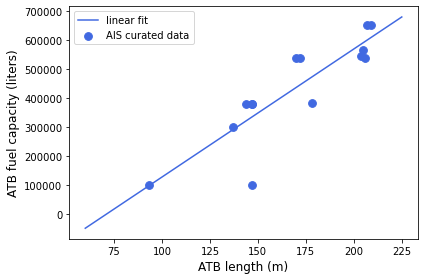

In [37]:
#~~~~ ATB (> 50 m) fuel capacity line fit ~~~~
C = oil_attrs['vessel_attributes']['atb']['fuel_fit_coefs']
test_length = numpy.arange(60,230,5)
test_atb_fit = ( 
    C[1] + 
    C[0]*test_length 
)

atbfig = plt.figure()
ax1 = atbfig.add_subplot(111)
ax1.scatter(
    atb_df['Vessel Length (AIS + <50 m correction)'][good_values],
    atb_df['Total Fuel Capacity (liters)'][good_values],
    60,
    label='AIS curated data',
    color='royalblue'
)
ax1.plot(test_length, test_atb_fit, c='royalblue', label='linear fit')
plt.xlabel('ATB length (m)',fontsize=12)
plt.ylabel('ATB fuel capacity (liters)',fontsize=12)
plt.tight_layout()
ax1.legend()
#plt.savefig('ATB_cargo_ais.png')
plt.show()
#plt.savefig(graphics_directory/'atb_fuel_fit.png')

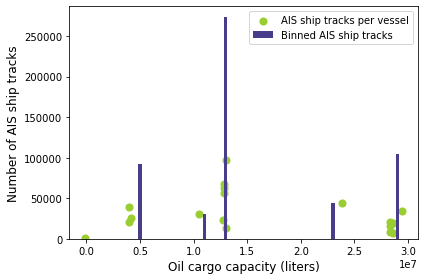

In [38]:
#~~~~ ATB (< 50 m) and tank barge cargo capacity weighting ~~~~
fig = plt.figure()
ax2 = fig.add_subplot(111)

# add binned-ship-track frequencies
ax2.bar(
    cargo_bin_centers,
    binned_atb_count_cargo,
    width=0.3e6,
    label='Binned AIS ship tracks',
    color='darkslateblue'
)

# add ais-curated frequency data 
ax2.scatter(
    atb_df['Cargo Capacity (liters)'][0:18],
    atb_data_df['COUNT'],
    50,
    label='AIS ship tracks per vessel',
    color='yellowgreen'
)

#labels, etc.
plt.xlabel('Oil cargo capacity (liters)',fontsize=12)
plt.ylabel('Number of AIS ship tracks',fontsize=12)
plt.tight_layout()
ax2.legend()
plt.savefig(oil_attrs['directories']['graphics'] + 'tank_barge_pings_binnedbycapacity.png', 
            bbox_inches='tight'
           )
plt.show() 

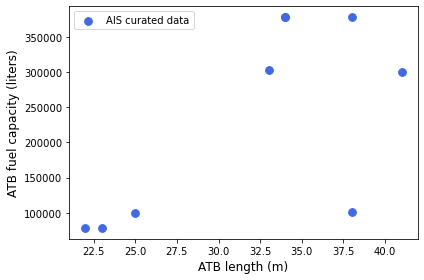

In [39]:
small = atb_df['Vessel length (AIS)']<50
atbfig = plt.figure()
ax1 = atbfig.add_subplot(111)
ax1.scatter(
    atb_df['Vessel length (AIS)'][small],
    atb_df['Total Fuel Capacity (liters)'][small],
    60,
    label='AIS curated data',
    color='royalblue'
)
#ax1.plot(test_length, test_atb_fit, c='royalblue', label='linear fit')
plt.xlabel('ATB length (m)',fontsize=12)
plt.ylabel('ATB fuel capacity (liters)',fontsize=12)
plt.tight_layout()
ax1.legend()
#plt.savefig('ATB_cargo_ais.png')
plt.show()

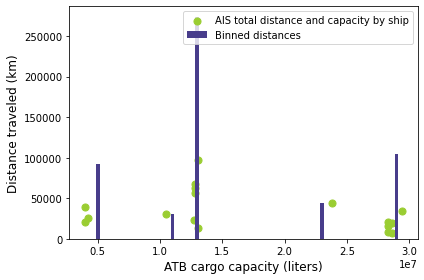

In [40]:
#~~~~ plot  ais pings by vessel lengths  and ais pings by binned lengths, for comparison~~~~
aisfig = plt.figure()
ax1 = aisfig.add_subplot(111)


# add binned-ship-track frequencies
ax1.bar(
    cargo_bin_centers,
    binned_atb_count_cargo,
    width=0.3e6,
    label='Binned distances',
    color='darkslateblue'
)

# add ais-curated frequency data 
good_data = atb_df['Cargo Capacity (liters)']>0
ax1.scatter(
    atb_df['Cargo Capacity (liters)'][good_data],
    atb_data_df['COUNT'][good_data],
    50,
    label='AIS total distance and capacity by ship',
    color='yellowgreen'
)

#labels, etc.
plt.xlabel('ATB cargo capacity (liters)',fontsize=12)
plt.ylabel('Distance traveled (km)',fontsize=12)
plt.tight_layout()
ax1.legend()
#plt.savefig('ATB_frequency_ais.png')
plt.show() 

In [41]:
oil_attrs['vessel_attributes']['tanker']

{'probability_full': 0.5,
 'probability_empty': 0.5,
 'probability_full_handymax': 0.628808864265928,
 'probability_empty_handymax': 0.37119113573407203,
 'min_cargo': 588253,
 'max_cargo': 185447000,
 'min_fuel': 33690.0,
 'min_length': 42,
 'max_fuel': 2984000.0,
 'max_length': 300,
 'handy_weights': [0.1145374449339207,
  0.039647577092511016,
  0.13215859030837004,
  0.030837004405286344,
  0.07048458149779736,
  0.05726872246696035,
  0.030837004405286344,
  0.06167400881057269,
  0.09251101321585903,
  0.06167400881057269,
  0.04405286343612335,
  0.048458149779735685,
  0.10572687224669604,
  0.06167400881057269,
  0.048458149779735685],
 'handy_capacity': [3402326.5080000004,
  6804653.016000001,
  10206979.524,
  13609306.032000002,
  17011632.540000003,
  20413959.048,
  23816285.556,
  27218612.064000003,
  30620938.572000004,
  34023265.080000006,
  37425591.58800001,
  40827918.096,
  44230244.604,
  47632571.112,
  51034897.620000005],
 'tanker_types': ['Smallest Tanker (

In [42]:
oil_attrs['vessel_attributes']['tanker']['length_bins']

((0.0, 61.0),
 (61.0, 151.0),
 (151.0, 201.0),
 (201.0, 251.0),
 (251.0, 301.0),
 (nan, nan),
 (nan, nan),
 (nan, nan),
 (nan, nan),
 (nan, nan),
 (nan, nan),
 (nan, nan),
 (nan, nan),
 (nan, nan),
 (nan, nan),
 (nan, nan),
 (nan, nan),
 (nan, nan),
 (nan, nan),
 (nan, nan))

In [43]:
oil_attrs['vessel_attributes']['atb']['fuel_capacity_bins']

[(75000, 100000),
 (100000, 125000),
 (125000, 150000),
 (150000, 175000),
 (175000, 200000),
 (200000, 225000),
 (225000, 250000),
 (250000, 275000),
 (275000, 300000),
 (300000, 325000),
 (325000, 350000),
 (350000, 375000),
 (375000, 400000),
 (400000, 425000),
 (425000, 450000),
 (450000, 475000),
 (475000, 500000),
 (500000, 525000),
 (525000, 550000),
 (550000, 575000),
 (575000, 600000),
 (600000, 625000),
 (625000, 650000),
 (650000, 675000)]

In [44]:
bins = []
center_points = []
for index in range(len(tanker_df['min length (m)']-1)):
    bins.append(
        (tanker_df['min length (m)'][index].tolist(), 
         tanker_df['max length (m)'][index].tolist()+1)
    )
    step_size = (
        tanker_df['max length (m)'][index].tolist() - 
        tanker_df['min length (m)'][index].tolist()
    )
    center_points.append(tanker_df['min length (m)'][index] + step_size/2)



In [45]:
sum(oil_attrs['vessel_attributes']['atb']['fuel_capacity_probability'])

1.0

In [46]:
numerator = binned_atb_count_by_fuel
denomintor = binned_atb_count_by_fuel.sum()
fuel_weights = numpy.around(
        numerator / denominator,
        decimals = 2
)

In [47]:
sum(fuel_weights)

1.0

In [48]:
numpy.sum(numpy.asarray(oil_attrs['vessel_attributes']['atb']['fuel_capacity_probability']))

1.0